## Выбор локации для скважины

Заказчиком исследования является добывающая комания `ГлавРосГосНефть`, которая занимается разработкой нефтяных месторождений.

**Цель проекта** — определить место для бурения новой скважины, где добыча принесёт наибольшую прибыль.

**Задача проекта** — построить модель машинного обучения, определяющую наиболее благоприятный для добычи нефти регион. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap*.

В качестве *источника данных* имеем пробы нефти в трёх регионах: в каждом регионе по 10 000 меторождений, в которых измерили качество нефти и объём её запасов.

### Шаг 1. Изучение и подготовка данных

In [245]:
# импорт библиотек и методов
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import urllib.request
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
from scipy import stats as st

> Данные геологической разведки трёх регионов находятся в файлах `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`, расположенных на *Яндекс.Диске*

Чтобы не прилагать файл с данными каждый раз при отправке, напишем код, позволяющий прочитать файл с любого компьютера.

In [246]:
# создание папки 'datsets' в директории
Path('datasets').mkdir(parents=True, exist_ok=True)

# создание словаря с именем файла и ссылкой на него
urls = {
   'geo_data_0': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/eh3kj3T18NjrrQ', 'datasets/geo_data_0.csv'),
    'geo_data_1': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/6-vqgQROc6vpNw', 'datasets/geo_data_1.csv'),
    'geo_data_2': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Xzpst4Q7ydNEwQ', 'datasets/geo_data_2.csv'),

}

for url in urls:
# проверка наличия файла 
    if not os.path.exists(urls.get(url)[1]):
        print(urls.get(url)[1], 'файл не найден, будет загружен из сети')
# скачивание файла по ссылке url и размещение файла по пути file_name
        urllib.request.urlretrieve(*urls.get(url))
     
df =  pd.read_csv(urls[url][1])

In [247]:
# чтение файлов и вывод первых пяти строк каждого файла
tables = ['datasets/geo_data_0.csv', 'datasets/geo_data_1.csv', 'datasets/geo_data_2.csv']
for table in tables:
    df = pd.read_csv(table)
    display(df.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Запишем каждую таблицу в отдельный файл.

In [248]:
# функция записи таблицы в переменную
def df_var(df_name, way):
    str = df_name
    globals()[str] = pd.read_csv(way)

In [249]:
# цикл присвоения даных
df_names = ['df0', 'df1', 'df2']
for df, t in zip(df_names, tables):
    df_var(df, t)
    
# вывод таблицы для проверки работы цикла
display(df0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Исходные данные:**

Для трёх загруженных таблиц данных информация в колонках означает следующее:

* *id* — уникальный идентификатор скважины;
* *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
* *product* — объём запасов в скважине (тыс. баррелей).

Загрузим библиотеку *sweetviz* для проведения тщательного EDA анализа.

In [250]:
# загрузка библиотеки методов для анализа данных
!pip install sweetviz

Defaulting to user installation because normal site-packages is not writeable



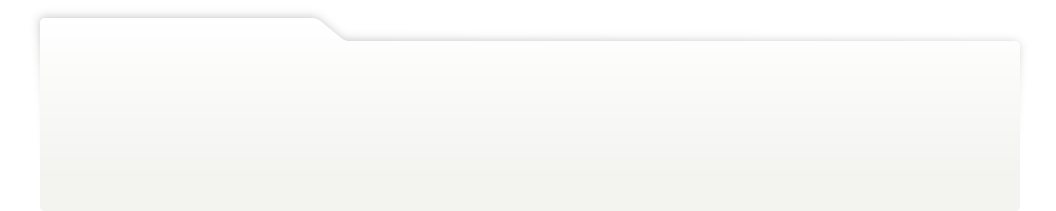
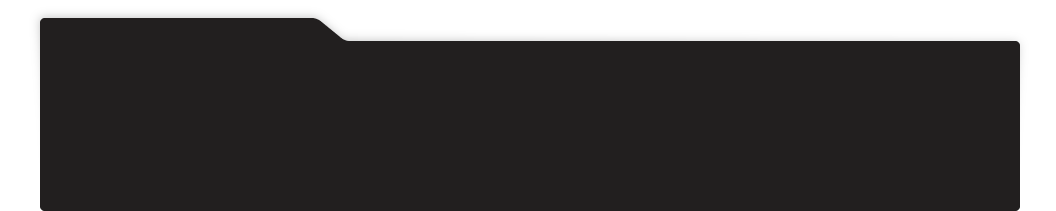
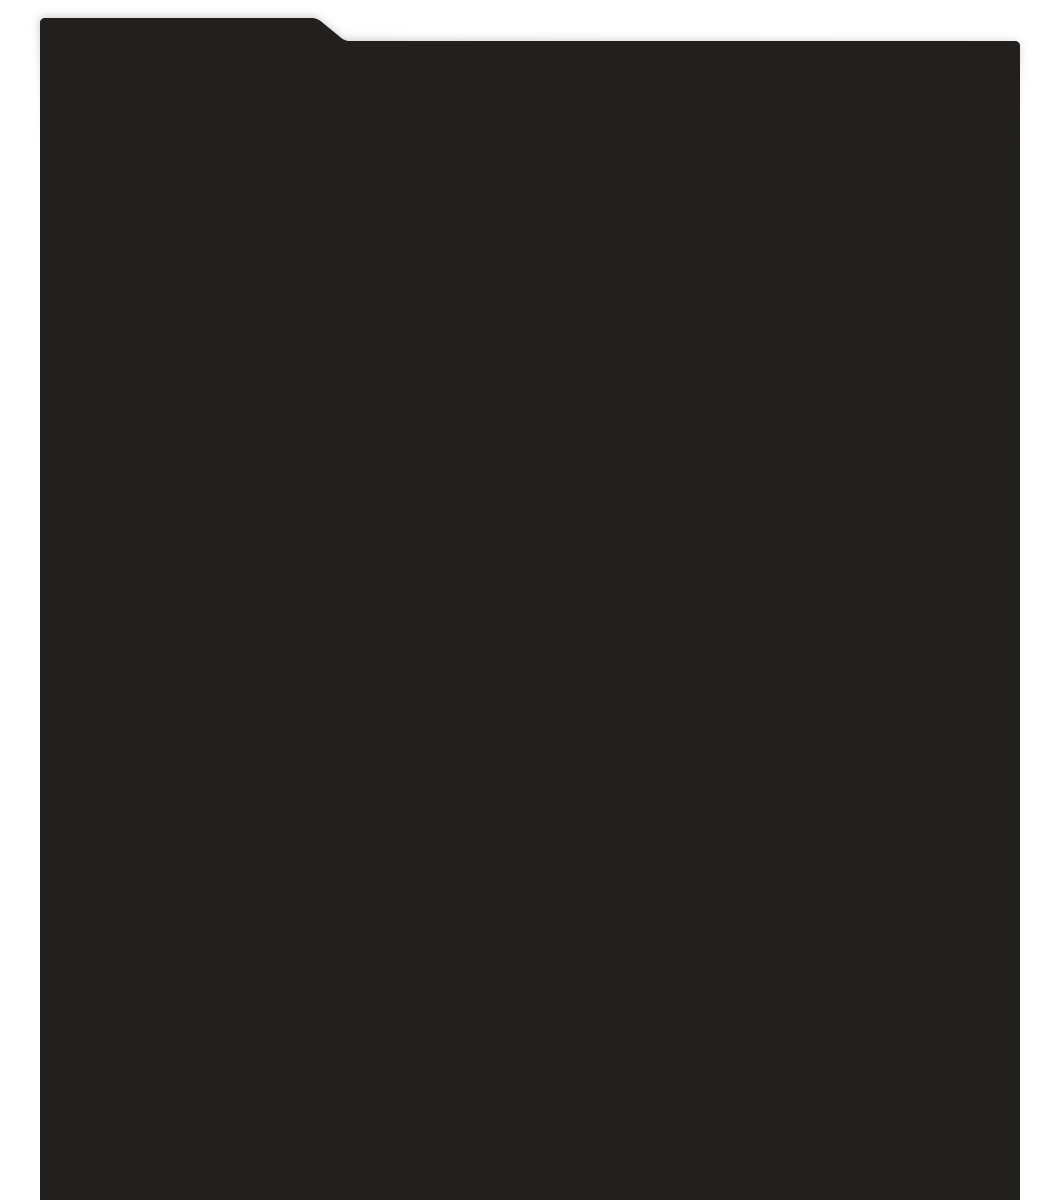
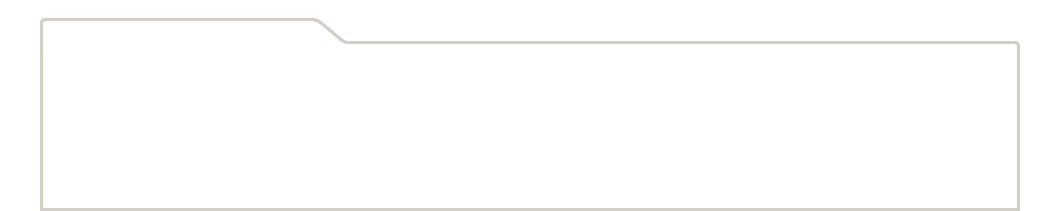
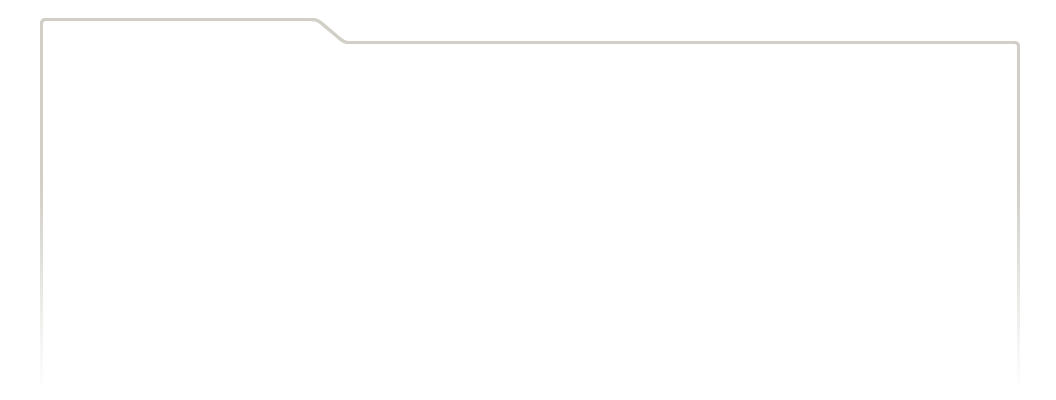
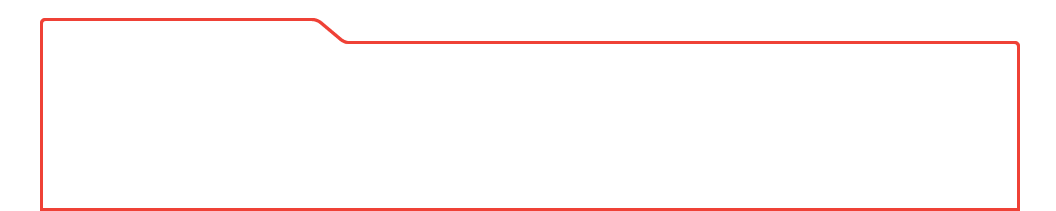
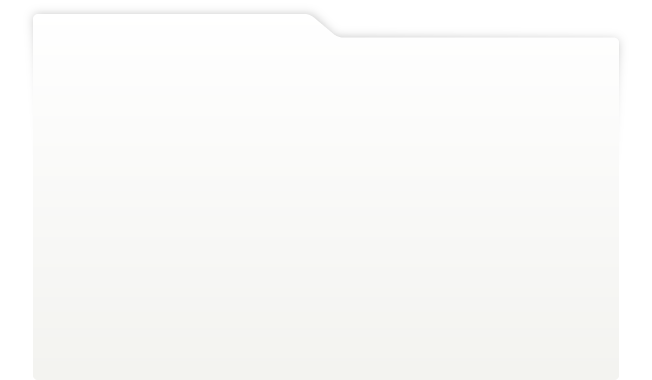
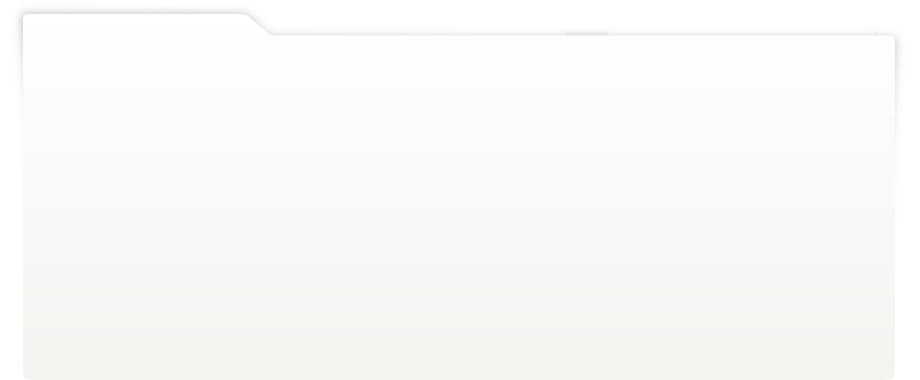
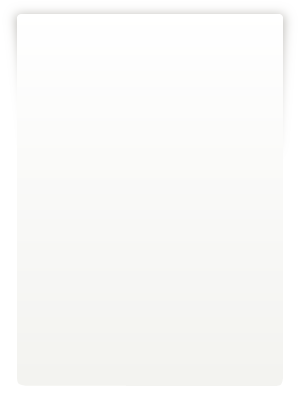
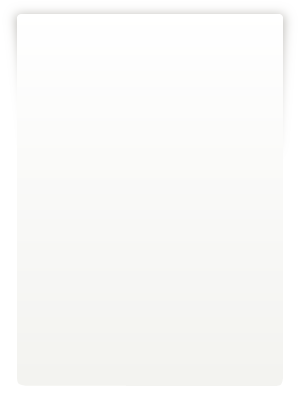
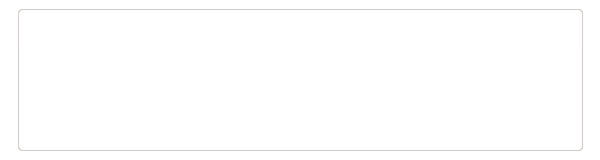
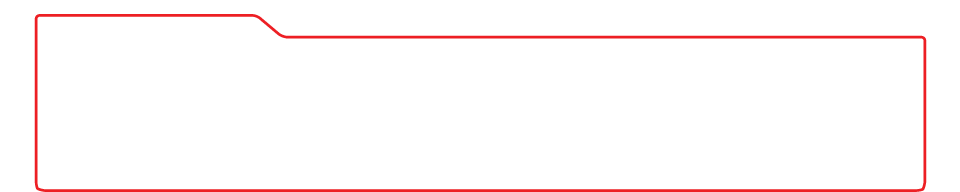
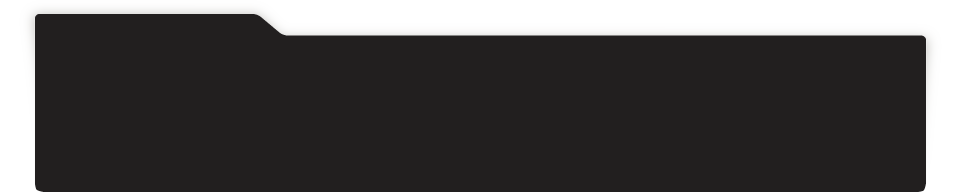
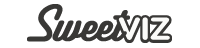
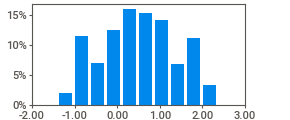
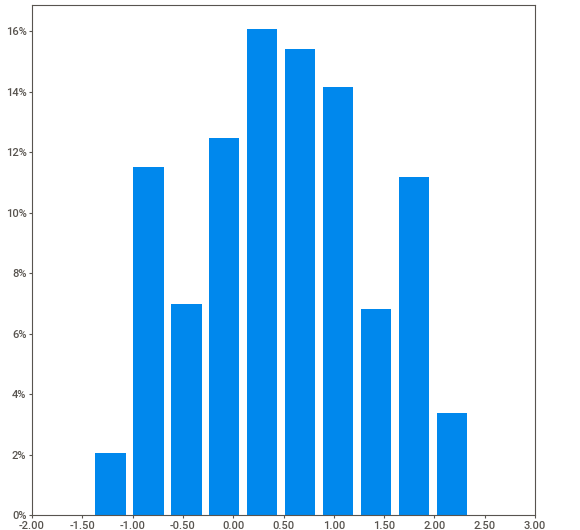
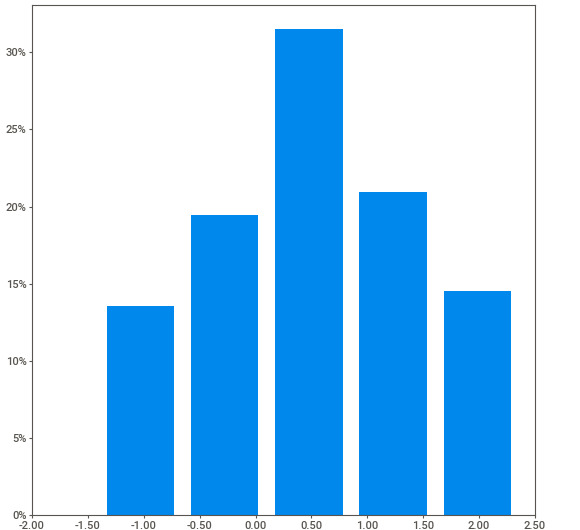
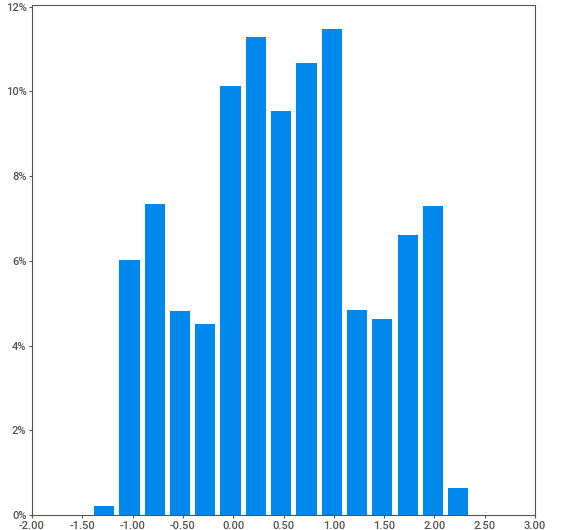
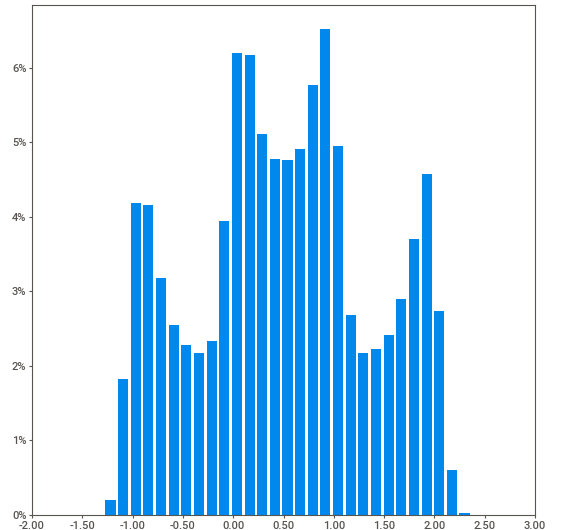
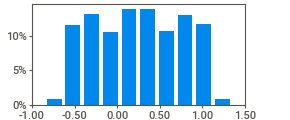
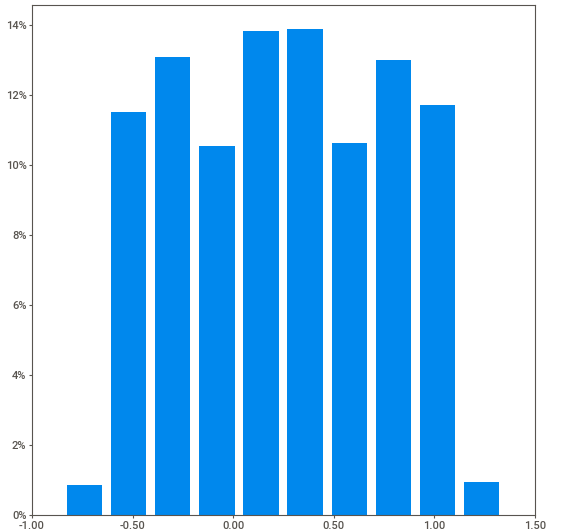
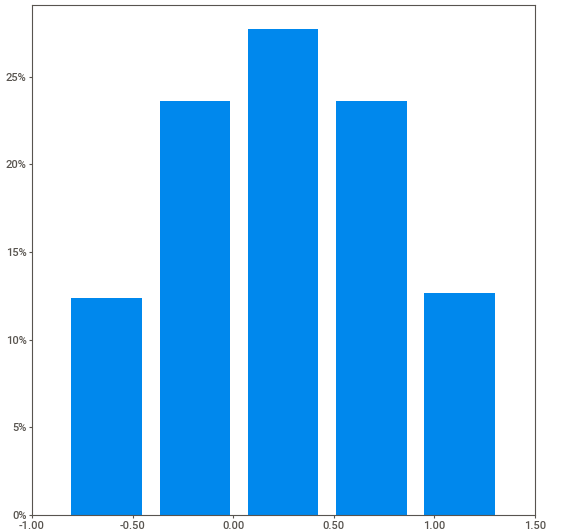
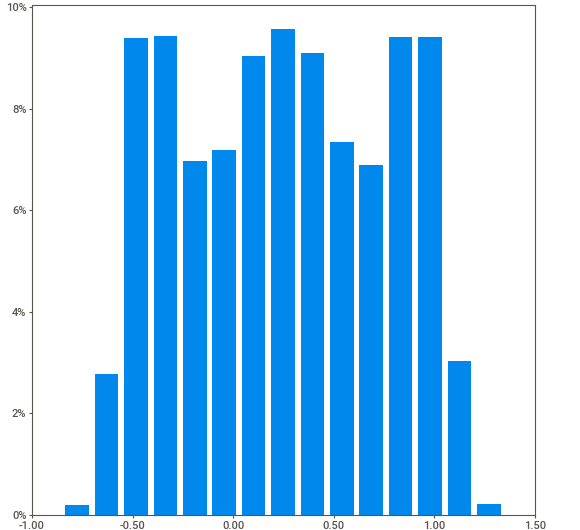
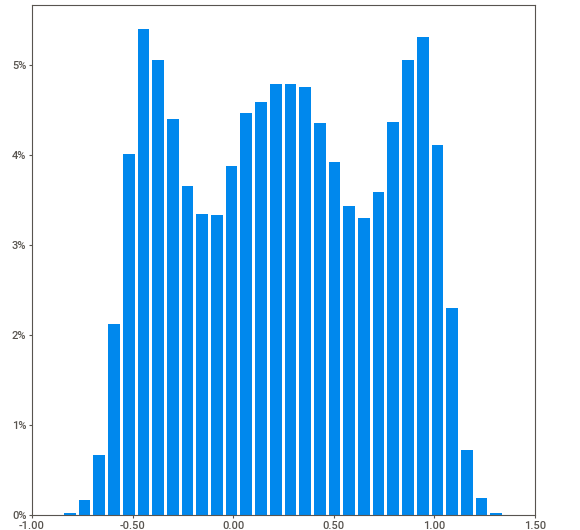
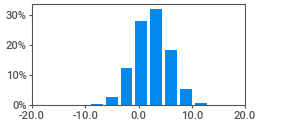
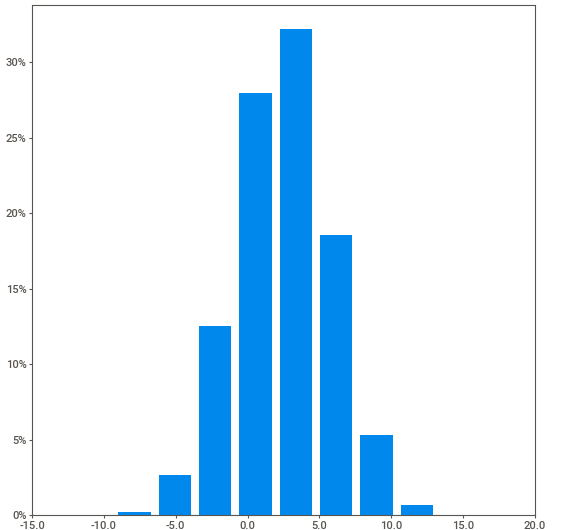
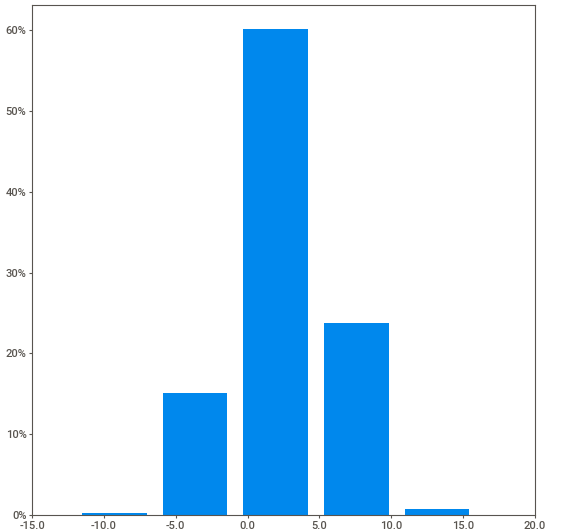
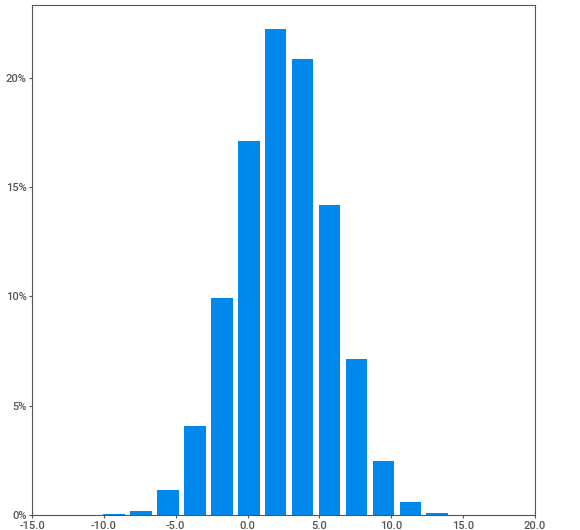
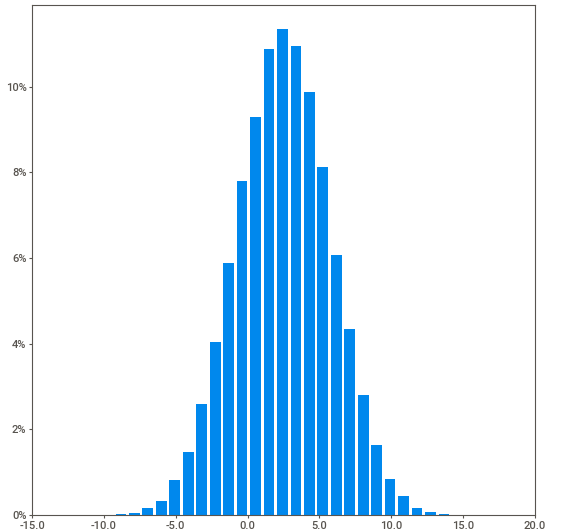
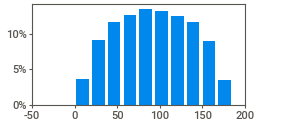
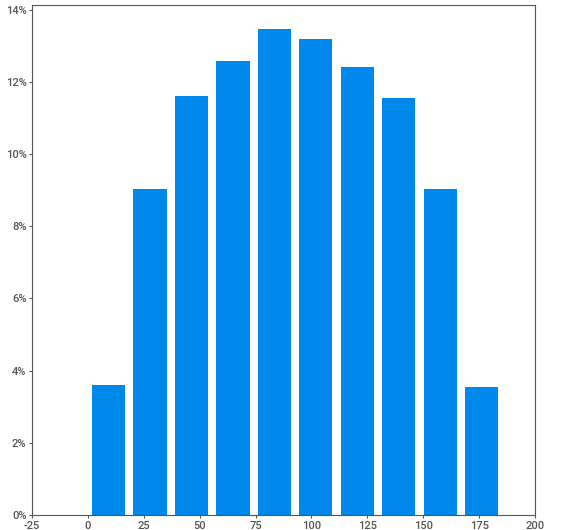
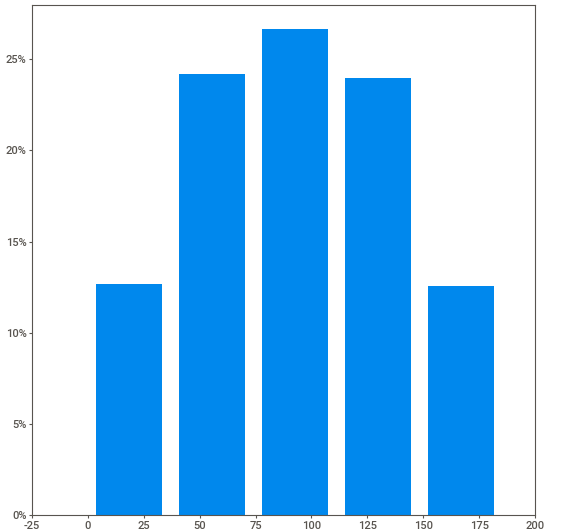
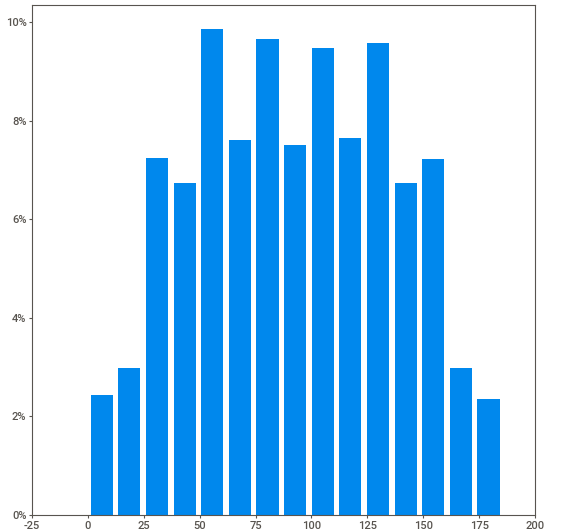
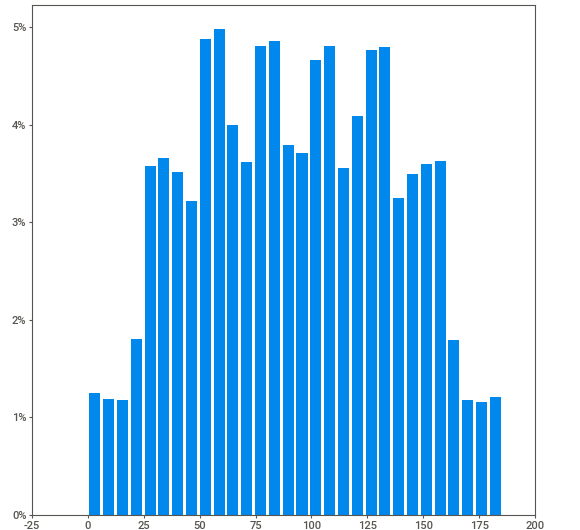
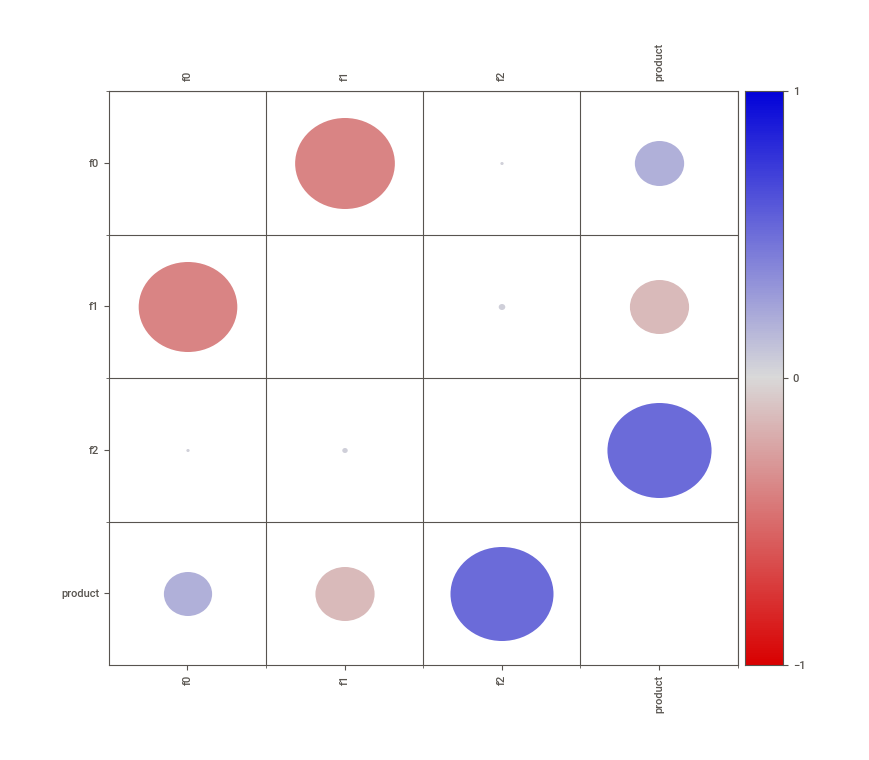
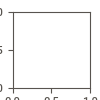

In [251]:
# вывод анализа скважин первого региона
import sweetviz as sv
report = sv.analyze([df0, 'geo_data_0'])
report.show_notebook(w=1500, h=500)

In [252]:
# получение информации о типах данных в таблице
df0.dtypes

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Проанализируем полученную информацию. Загруженная таблица содержит 5 колонок с типами данных:
* `float64`
* `object`

Из аналитической сводки данных получаем следующее: максимальные и минимальные значения признаков точек *f0, f1* несильно различаются (к тому же размах выборки по указанным признакам *RANGE* находится примерно в одинаковых порядках чисел). Признак *f2* отличается от остальных. Минимальное количество добытой нефти в скважине первого региона - 0 тыс.бареллей. Дублирующихся строк не имеется, однако присутствуют дубликаты в столбце `id`, т.к. показатель *DISTINCT* (уникальные значения) не равен 100%.
От дубликатов в столбце `id` необходимо избавиться.

In [253]:
# просмотр дубликатов в столбце 'id'
values = ['HZww2', 'QcMuo', 'Tdehs', 'TtcGQ', 'bsk9y', 'A5aEY', 'AGS9W', 'bxg6G', 'fiKDv', '74z30']
display(df0.query('id in @values'))

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Действительно, видим, что в столбце `id` встречаются одинаковые наименования, т.е. в нескольких экземплярах присутствуют показатели одних и тех же скважин региона. Поскольку у нас нет информации о том, что именно означают показатели признаков точек и как с этими значениями можно работать, то мы просто избавимся от ненужных значений.

In [254]:
# удаление дубликатов
df0 = df0.drop_duplicates(subset='id')

In [255]:
# просмотр дубликатов в столбце 'id'
values = ['HZww2', 'QcMuo', 'Tdehs', 'TtcGQ', 'bsk9y', 'A5aEY', 'AGS9W', 'bxg6G', 'fiKDv', '74z30']
display(df0.query('id in @values'))

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
64022,74z30,0.741456,0.459229,5.153109,140.771492
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078


Дубликаты удалены.

Чтобы не выводить аналитические сводки по отдельности для двух следующих таблиц, воспользуемся функцией *.compare()* библиотеки *sweetviz* и сделаем только одну сводку данных.


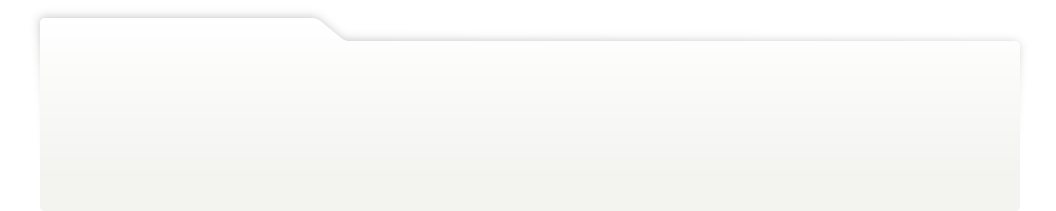
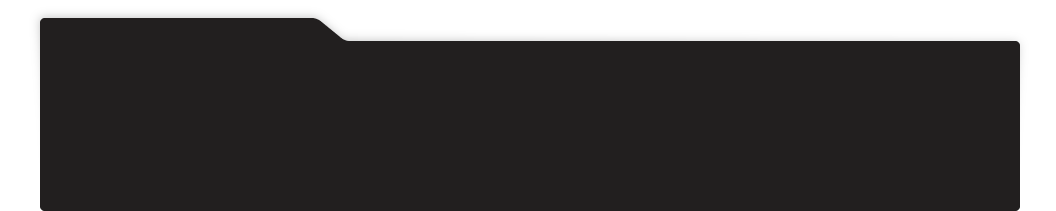
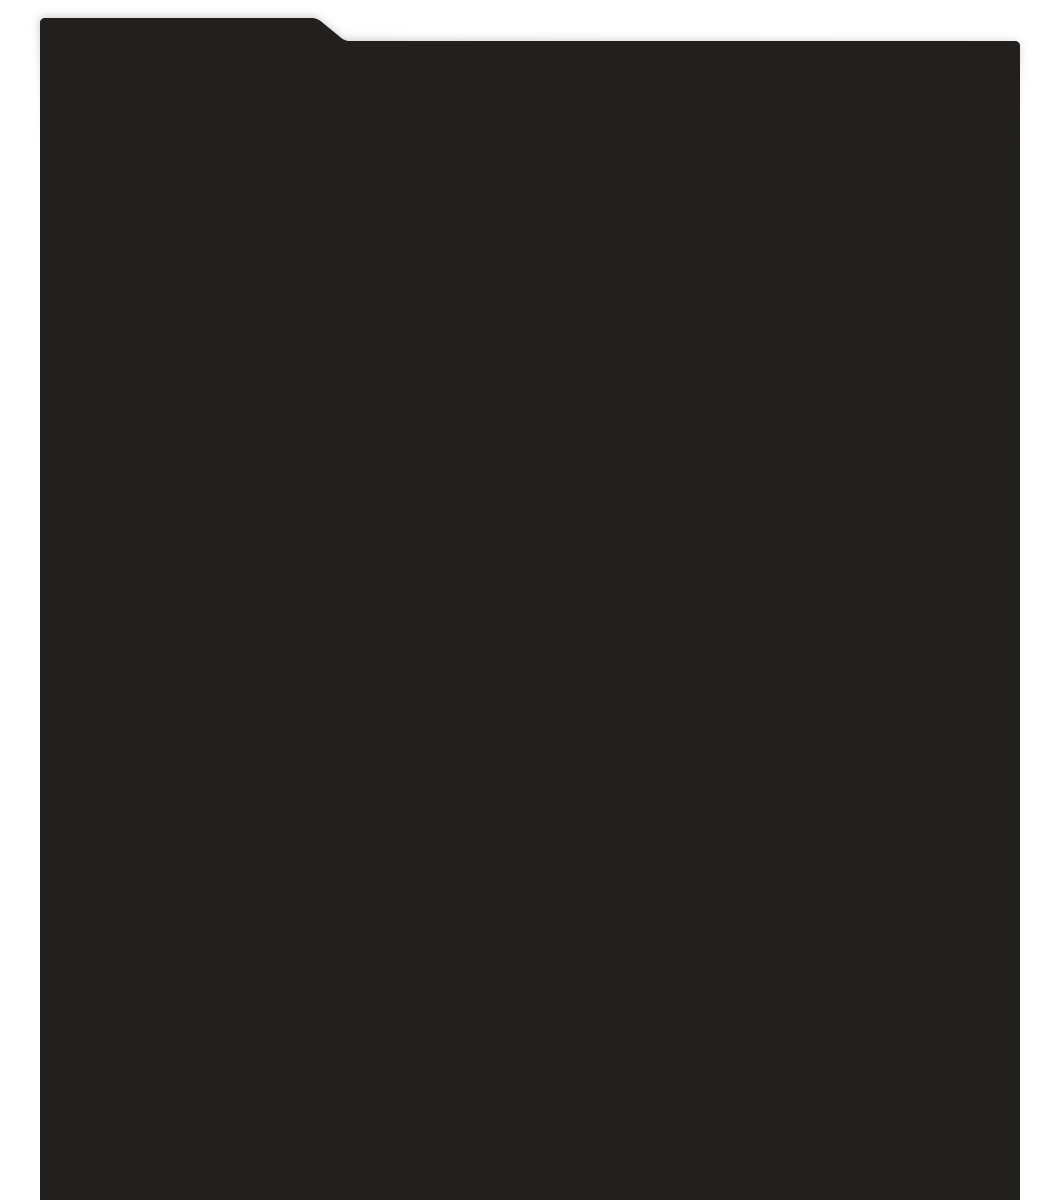
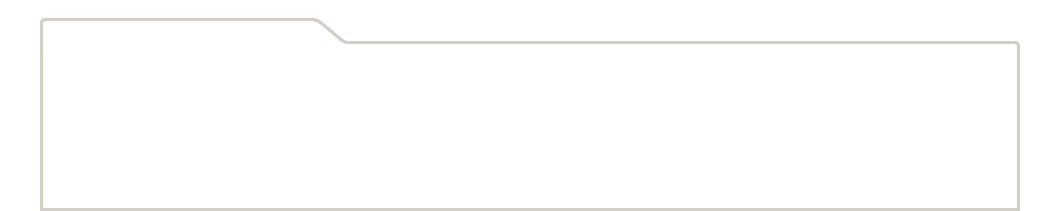
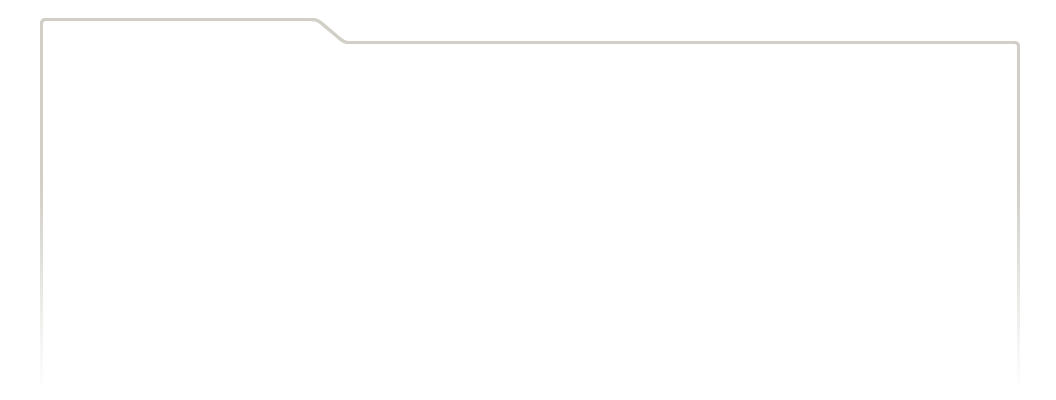
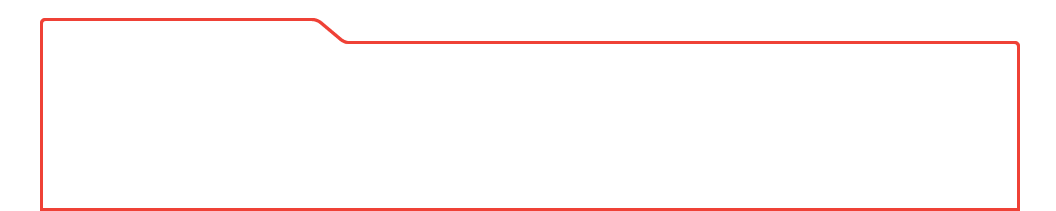
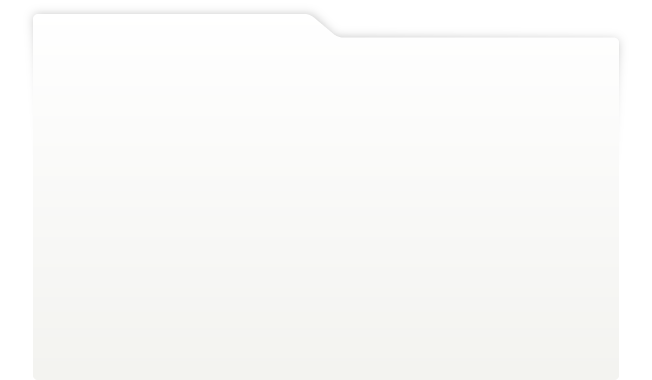
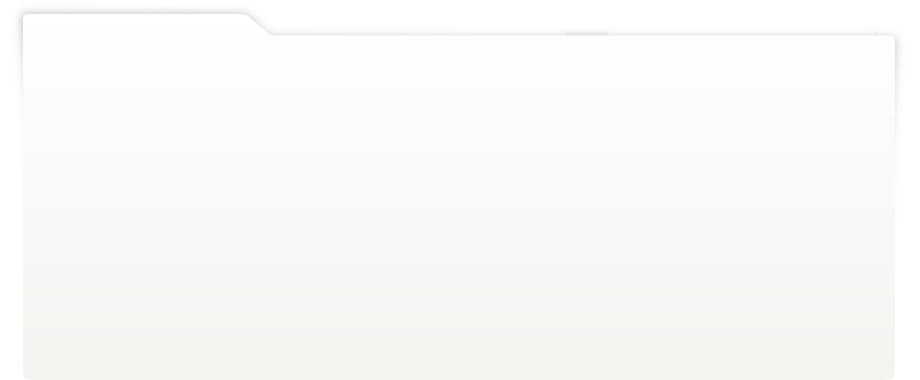
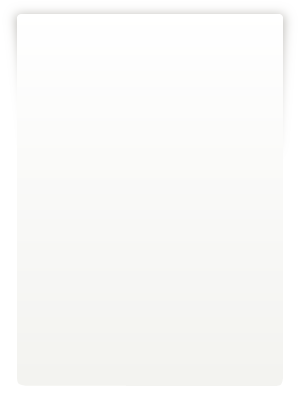
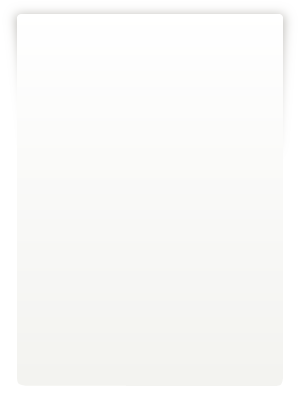
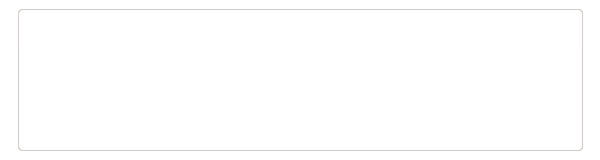
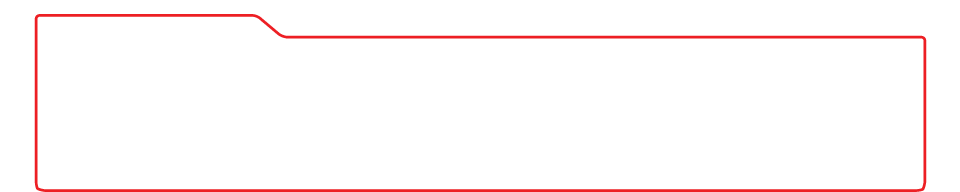
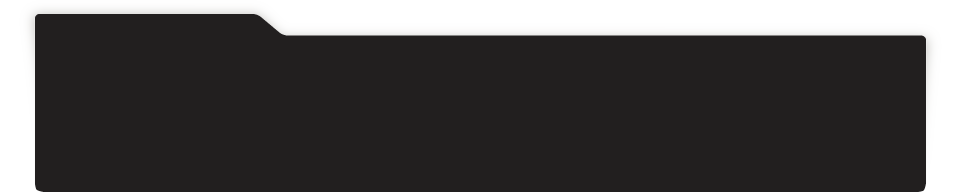
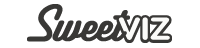
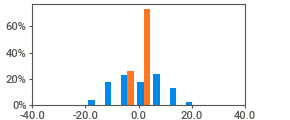
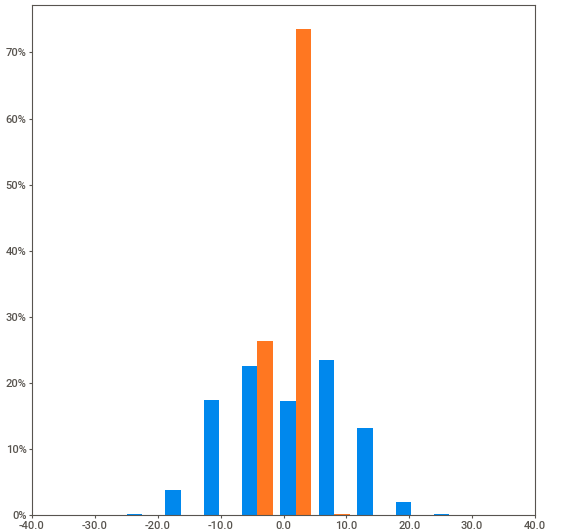
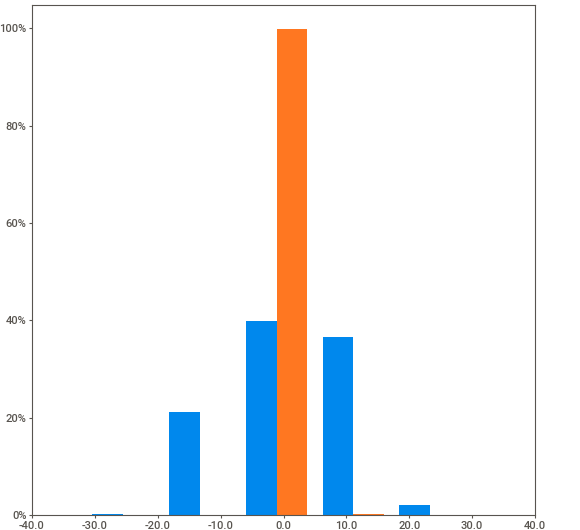
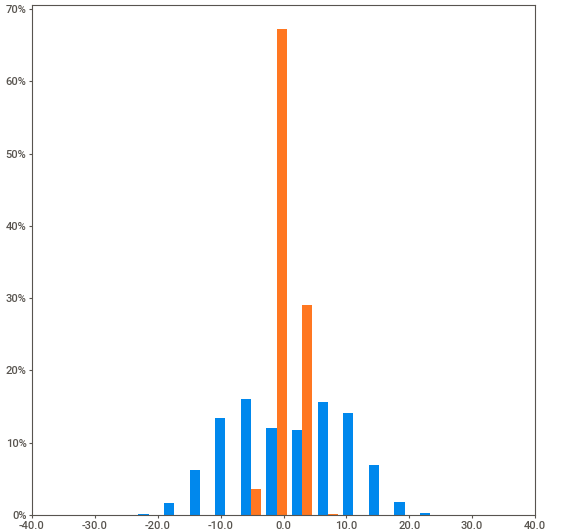
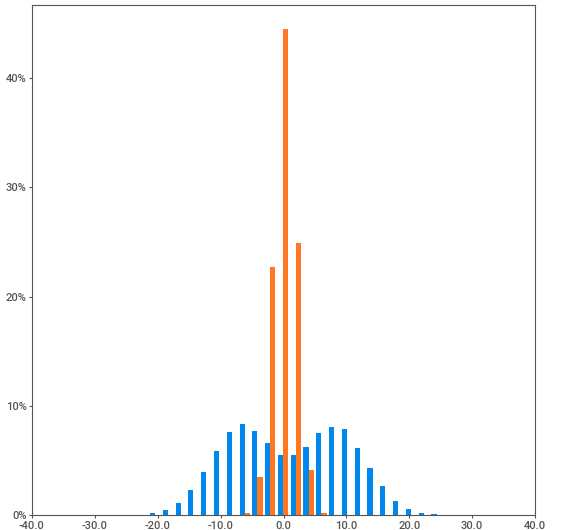
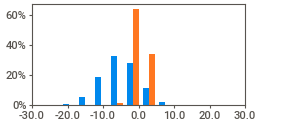
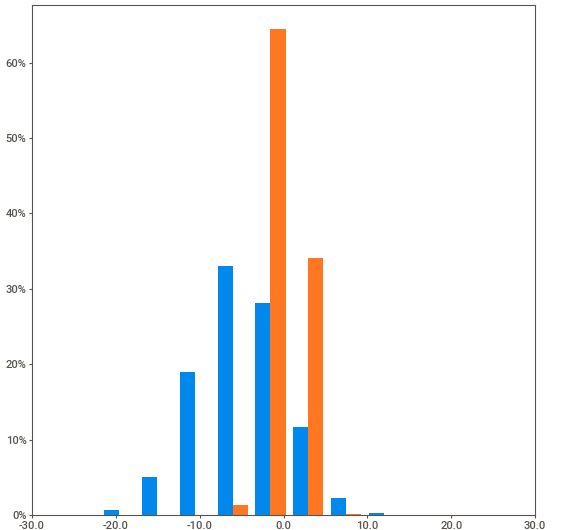
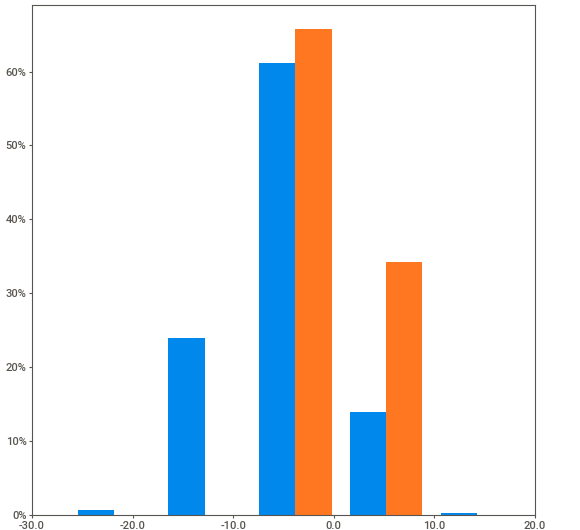
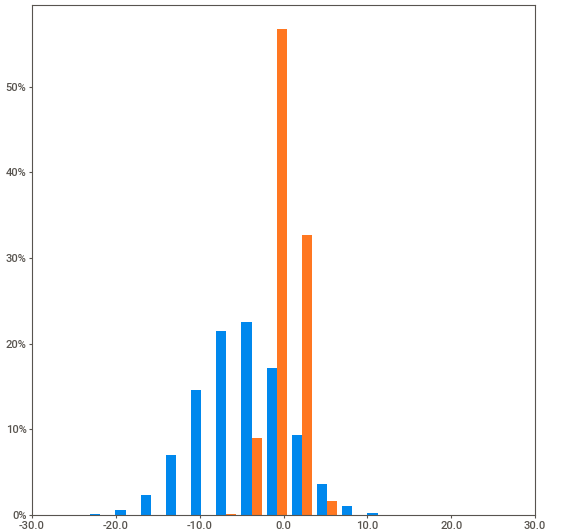
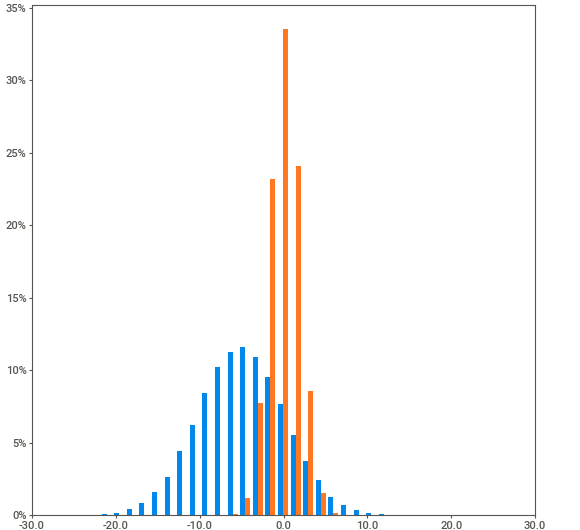
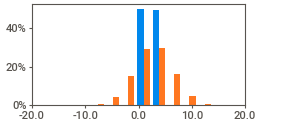
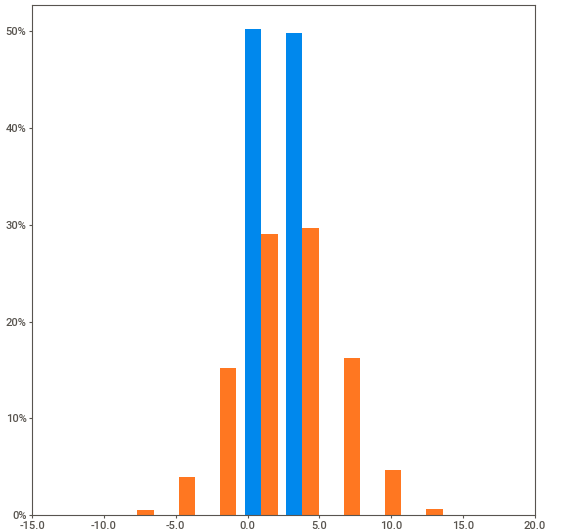
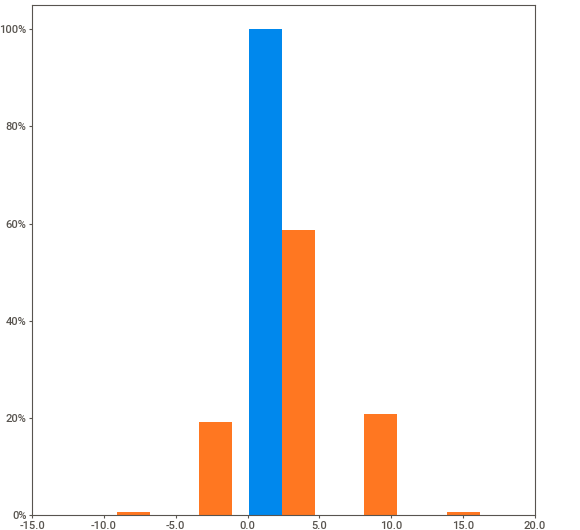
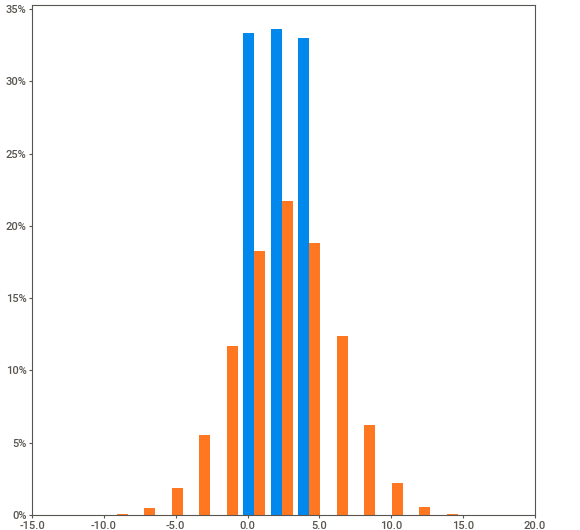
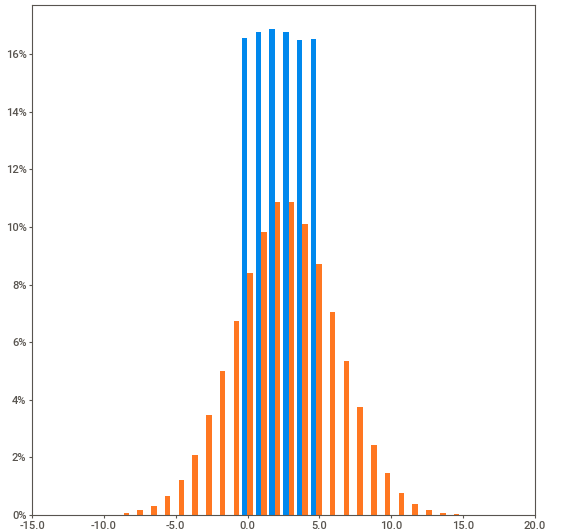
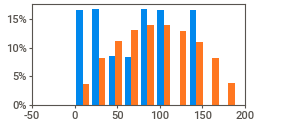
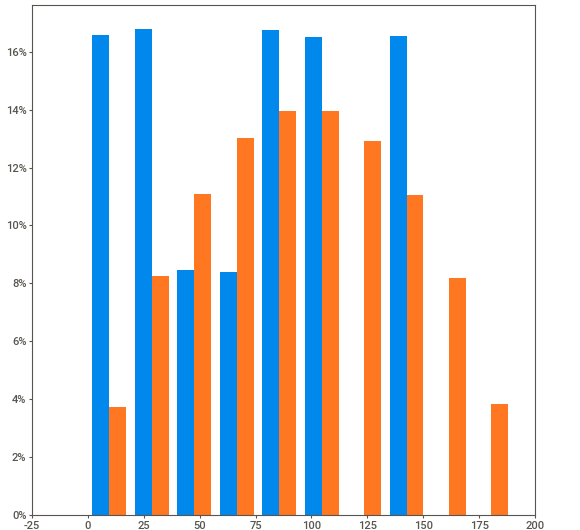
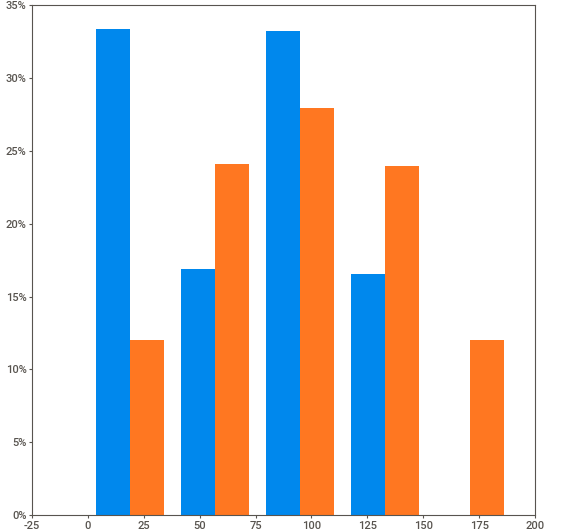
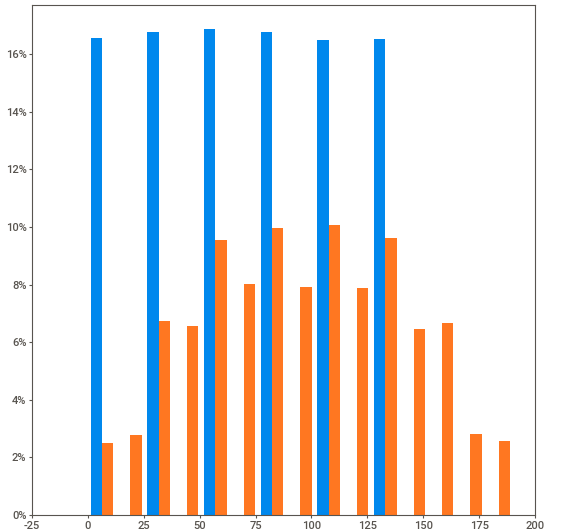
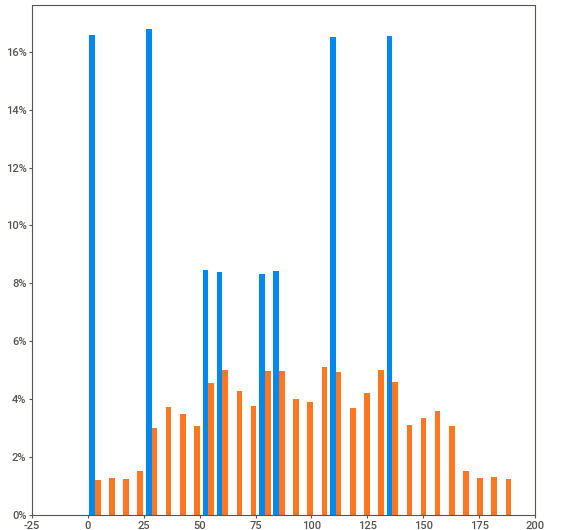
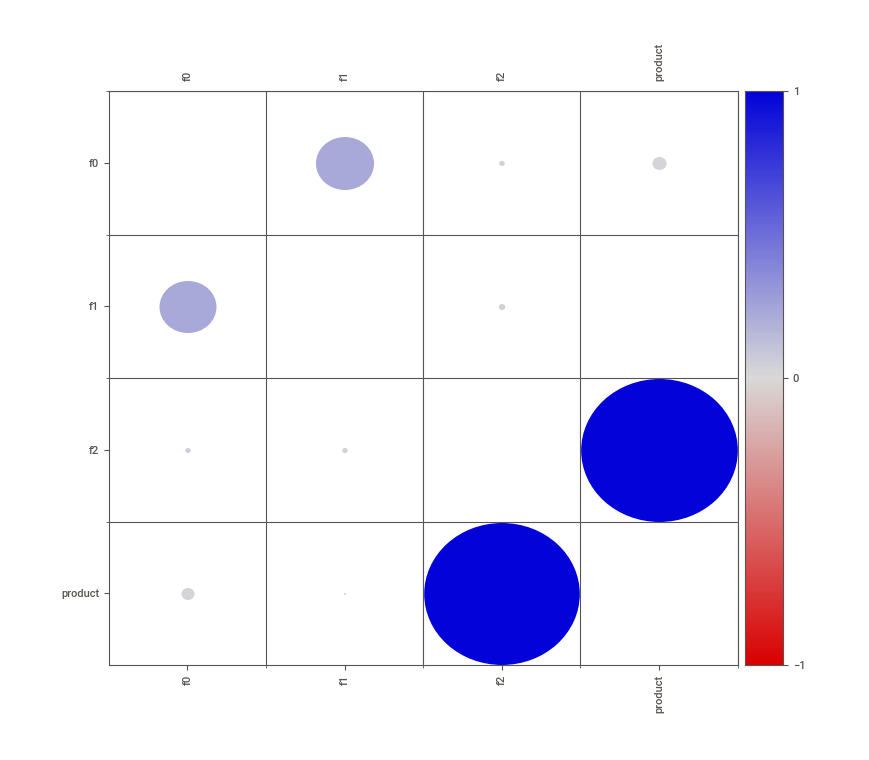
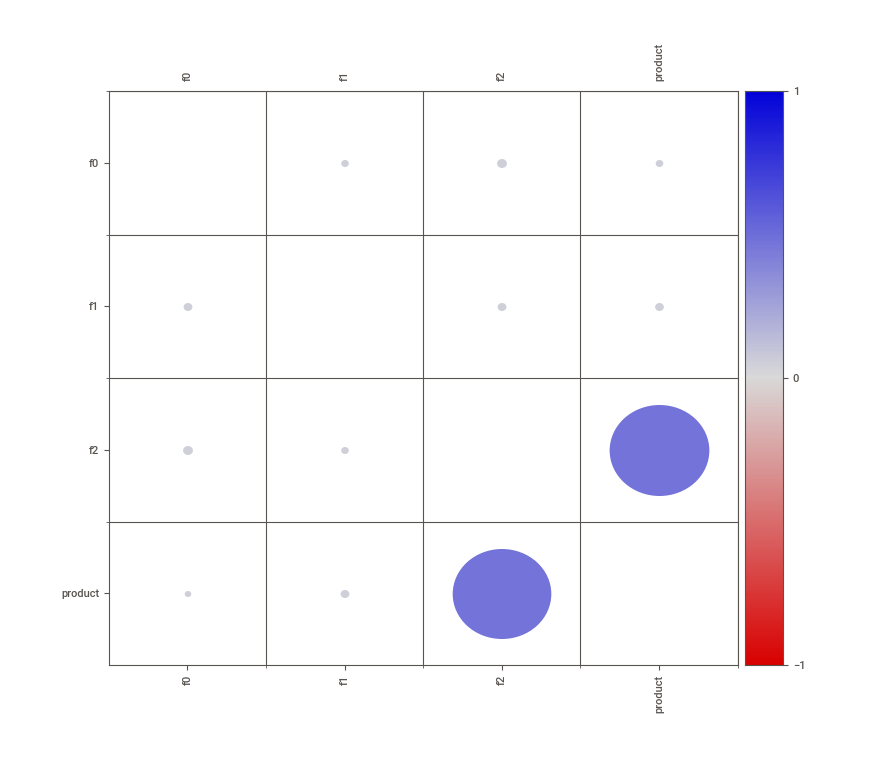

In [256]:
# вывод аналитической сводки для скважин второго и третьего регионов
report = sv.compare([df1, 'geo_data_1'], [df2, 'geo_data_2'])
report.show_notebook(w=1500, h=500)

In [257]:
# получение информации о типах данных в таблицах
print(df1.dtypes, df2.dtypes)

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


Содержание таблиц и типы данных в них аналогичны таким же критериям предыдущей таблицы.

Сохраняется тенденция распределения максимальных и минимальных значений и размахов признаков точек: признаки *f0, f1* по шкале расположены ближе друг к другу, в то время как признак *f2* находится в стороне. Имеем дубликаты в колонке `id` в обеих таблицах. Удаляем дубликаты.

In [258]:
# удаление дубликатов
df1, df2 = df1.drop_duplicates(subset='id'), df2.drop_duplicates(subset='id')

Чтобы приступить к обучению модели, необходимо **подготовить входные данные** для каждого из трёх регионов:

* все имеющиеся признаки привести к количественному формату (в нашем случае признаки изначально представлены в виде количественного формата)
* разделить исходные данные на признаки (все, кроме колонки `product` и `id`) и целевой признак (колонка `product`)
* разбить данные на две части: *обучающую и валидационную* выборки

Перечисленные выше операции проводим последовательно для каждого региона.

In [259]:
# деление датафрейма на признаки и целевой признак
features_0 = df0.drop(['id', 'product'], axis=1)
target_0 = df0['product']

# разбиение данных на две выборки
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

# проверка размеров полученных наборов данных
features_ = [features_train_0, features_valid_0]
target_ = [target_train_0, target_valid_0]

# вывод размера для проверки
for f,t in zip(features_, target_):
    print(f.shape, t.shape)

(74992, 3) (74992,)
(24998, 3) (24998,)


In [260]:
# деление датафрейма на признаки и целевой признак
features_1 = df1.drop(['id', 'product'], axis=1)
target_1 = df1['product']

# разбиение данных на две выборки
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

# проверка размеров полученных наборов данных
features_ = [features_train_1, features_valid_1]
target_ = [target_train_1, target_valid_1]

# вывод размера для проверки
for f,t in zip(features_, target_):
    print(f.shape, t.shape)

(74997, 3) (74997,)
(24999, 3) (24999,)


In [261]:
# деление датафрейма на признаки и целевой признак
features_2 = df2.drop(['id', 'product'], axis=1)
target_2 = df2['product']

# разбиение данных на две выборки
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

# проверка размеров полученных наборов данных
features_ = [features_train_2, features_valid_2]
target_ = [target_train_2, target_valid_2]

# вывод размера для проверки
for f,t in zip(features_, target_):
    print(f.shape, t.shape)

(74997, 3) (74997,)
(24999, 3) (24999,)


In [262]:
# просмотр первых пяти строк признаков одной из обучающих выборок
features_train_0.head()

,f0,f1,f2
75167,1.175747,-0.382577,2.280279
43242,-0.878080,0.162056,-1.655183
91995,-0.064050,0.320469,0.861030
5094,0.055304,0.884562,-0.276966
78252,-0.143708,1.026059,1.291161


Разбросы значений в колонках датафрейма отличаются. Те признаки, у которых разброс данных значиельный, будут автоматически признаны алгоритмами моделей машинного обучения более важными. В действительности это не так. Чтобы признаки считались равнозначными, воспользуемся **мастабированием признаков**. Применим метод **стандартизации данных** с помощью структуры данных *StandardScaler*.

In [263]:
# функция стандартизации и обновления датафрейма
def scaler_method(data):
    numeric = ['f0', 'f1', 'f2']
    col_names = list(data.columns)
    data[numeric] = scaler.transform(data[numeric])
    data = pd.DataFrame(data, columns=col_names)
    return data

In [264]:
# отключение предупреждения
pd.options.mode.chained_assignment = None

# применение функции к данным первого региона
numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_train_0[numeric])
features_train_0 = scaler_method(features_train_0)
features_valid_0 = scaler_method(features_valid_0)

# применение функции к данным второго региона
scaler.fit(features_train_1[numeric])
features_train_1 = scaler_method(features_train_1)
features_valid_1 = scaler_method(features_valid_1)

# применение функции к данным третьего региона
scaler.fit(features_train_2[numeric])
features_train_2 = scaler_method(features_train_2)
features_valid_2 = scaler_method(features_valid_2)

In [265]:
# вывод первых пяти значений преобразованных признаков одной из обучающих выборок
features_train_0.head()

,f0,f1,f2
75167,0.776287,-1.255120,-0.067528
43242,-1.580378,-0.176704,-1.281795
91995,-0.646319,0.136966,-0.505430
5094,-0.509367,1.253916,-0.856553
78252,-0.737723,1.534093,-0.372715


**Вывод:**

Данные изучены и подготовлены к обучению.

### Обучение и проверка модели

Для каждого отбранного региона обучим модель линейной регрессии, т.к. она ведёт себя наиболее предсказуемо. Посмотрим на метрику качества *RMSE* и средний запас предсказанного сырья по регионам и сравним между собой.

In [266]:
# функция расчёта среднего запаса предсказанного сырья
def linear_model(features_train, features_valid, target_train, target_valid, region_number):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = round(math.sqrt(mean_squared_error(target_valid, predicted_valid)), 2)
    print('Метрика RMSE для региона {0} = {1}'.format(region_number, rmse))
    print('Средний запас предсказанного сырья для региона {0} = {1} тыс.баррелей'.format(region_number, round(predicted_valid.mean(), 2)))
    return predictions.append(predicted_valid)

In [267]:
# применение функции к данным трёх регионов
features_train_list = [features_train_0, features_train_1, features_train_2]
features_valid_list = [features_valid_0, features_valid_1, features_valid_2]
target_train_list = [target_train_0, target_train_1, target_train_2]
target_valid_list = [target_valid_0, target_valid_1, target_valid_2]
region = [1, 2, 3]

predictions = []
for f_t, f_v, t_t, t_v, region in zip(features_train_list, features_valid_list, target_train_list, target_valid_list, region):
    linear_model(f_t, f_v, t_t, t_v, region)

Метрика RMSE для региона 1 = 37.85
Средний запас предсказанного сырья для региона 1 = 92.79 тыс.баррелей
Метрика RMSE для региона 2 = 0.89
Средний запас предсказанного сырья для региона 2 = 69.18 тыс.баррелей
Метрика RMSE для региона 3 = 40.08
Средний запас предсказанного сырья для региона 3 = 94.87 тыс.баррелей


Значения метрики RMSE и среднего запаса предсказанного сырья в первом и третьем регионе близки. Квадратный корень из средней квадратической ошибки в указанных скважинах составляет почти половину от среднего значения, это говорит о том, что разница между фактическими и предсказанными значениями достаточно большая. Средний запас предсказанного сырья во втором регионе значительно ниже, чем в двух других, однако разброс значений не такой сильный. Разница между фактическими и предсказанными значениями совсем небольшая.

**Вывод:**

Модели линейных регрессий обучены, значения метрик качества проанализированы.

### Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Создадим переменные для расчёта в соответствии с исходными данными *(описано выше)*.

In [268]:
# создание перменных для расчёта 
QUANTITY = 200 # количество разработанных скважин в регионе
BUDGET = 10000000000 # бюджет на разработку скважин в регионе
PRICE_PER_BARREL = 450 # цена за один баррель сырья
PRICE_PER_PRODUCT_UNIT = PRICE_PER_BARREL * 1000 # доход с каждой единицы продукта

Рассчитаем достаточный объём сырья для безубыточной работы компании: бюджет на разработку скважин в регионе поделим на количество разработанных скважин и на доход с каждой единицы продукта.

In [269]:
# расчёт достаточного объёма сырья
V_MIN = BUDGET / QUANTITY / PRICE_PER_PRODUCT_UNIT
print('Достаточный объём сырья, полученный из одной скважины =', round(V_MIN, 2), 'тыс.баррелей')

Достаточный объём сырья, полученный из одной скважины = 111.11 тыс.баррелей


Произведём расчёт среднего объёма сырья по известным (непредсказанным) значениям. Для этого напишем функцию.

In [270]:
# функция расчёта среднего объёма сырья в регионе
def v_product(df, a):
    V = round(df['product'].mean(), 2)
    print('Средний объём сырья в регионе {0} = {1} тыс.баррелей'.format(a, V))

In [271]:
# применение функции
v_product(df0, 1)
v_product(df1, 2)
v_product(df2, 3)

Средний объём сырья в регионе 1 = 92.5 тыс.баррелей
Средний объём сырья в регионе 2 = 68.82 тыс.баррелей
Средний объём сырья в регионе 3 = 95.0 тыс.баррелей


Средний объём сырья в регионах ниже достаточного для безубыточной работы компании объёма сырья, поэтому необходимо отбирать 200 лучших скважин для добычи нефти, чтобы работать безубыточно.

**Вывод:**

Осуществлена подготовка к расчёту прибыли.

### Расчёт прибыли и рисков 

Создадим функцию расчёта прибыли с использованием предсказаний моделей линейной регрессии. С помощью предсказаний определим 200 лучших скважин региона, а объём сырья в отобранных скважинах возьмём из уже имеющихся данных геологической разведки.

In [272]:
# функция расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit_func(predicted_valid, target_valid, df, region_number):
    prediction = pd.Series(predicted_valid, index=target_valid.index) # преобразование предсказаний в Series
    i = prediction.sort_values(ascending=False).head(200).index # нахождение индексов 200 лучших скважин
    S = df['product'][i].sum() # расчёт оборота компании в тыс.бареллей
    profit = round((S * PRICE_PER_PRODUCT_UNIT - BUDGET), 2) # расчёт валовой прибыли компании в рублях
    print('Валовая прибыль в регионе {0} после выбора 200 лучших скважин = {1} руб.'.format(region_number, profit))

In [273]:
# применение функции расчёта прибыли
profit_func(predictions[0], target_valid_0, df0, 1)
profit_func(predictions[1], target_valid_1, df1, 2)
profit_func(predictions[2], target_valid_2, df2, 3)

Валовая прибыль в регионе 1 после выбора 200 лучших скважин = 3365187237.7 руб.
Валовая прибыль в регионе 2 после выбора 200 лучших скважин = 2415086696.68 руб.
Валовая прибыль в регионе 3 после выбора 200 лучших скважин = 2501283853.28 руб.


Теперь напишем функцию для расчёта прибыли, которую будем использовать при подсчёте рисков *(без вывода результатов на экран)*.

In [274]:
# функция расчёта прибыли при подсчёте рисков
def revenue(target_valid, predicted_valid, count):
    probs_sorted = predicted_valid.sort_values(ascending=False)
    selected = target_valid[probs_sorted.index][:count]
    return selected.sum() * PRICE_PER_PRODUCT_UNIT - BUDGET

Чтобы выбрать наиболее подходящий для разработки скважин регион, необходимо оценить риски, а именно вероятность уйти в минус, т.е. получить отрицательную прибыль. Также рассчитаем среднюю прибыль для каждого региона и 95% доверительный интервал, в котором с вероятностью 95% будет находиться значение прибыли.

Воспользуемся техникой Bootstrap для создания 1000 произвольных выборок из уже имеющихся и проведём расчёты.

In [275]:
# функция расчёта параметров выборок
def parameters(target, probabilities, region_number):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        fraction = 500 / len(target)
        target_subsample = target.sample(frac=fraction, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
    
        values.append(revenue(target_subsample, probs_subsample, 200))

    values = pd.Series(values)
    mean_revenue = round(values.mean(), 2)
    confidence_interval_lower_border = round(values.quantile(0.025), 2)
    confidence_interval_upper_border = round(values.quantile(0.975), 2)
    confidence_interval = (confidence_interval_lower_border, confidence_interval_upper_border)
    risk = (values < 0).mean()
    print('Средняя валовая прибыль в регионе {0} = {1} руб.\n95% доверительный интервал ={2}\nРиск убытков = {3}'.format(region_number, mean_revenue, confidence_interval, risk))

In [244]:
# расчёт показателей для трёх регионов
for p, t_v, r in zip(predictions, target_valid_list, region):
    i = r - 1
    prediction = pd.Series(predictions[i], index=t_v.index)
    parameters(t_v, prediction, r)

Средняя валовая прибыль в регионе 1 = 409428038.62 руб.
95% доверительный интервал =(-131536028.7, 944395582.75)
Риск убытков = 0.071
Средняя валовая прибыль в регионе 2 = 536902587.49 руб.
95% доверительный интервал =(114527902.9, 970787911.0)
Риск убытков = 0.009
Средняя валовая прибыль в регионе 3 = 353790362.73 руб.
95% доверительный интервал =(-159194031.19, 875652502.87)
Риск убытков = 0.102


Риск убытков в первом и третьем регионах намного выше, чем во втором регионе. Самый высокий средний показатель валовой прибыли наблюдается во втором регионе. Также только во втором регионе в 95% доверительном интервале не содержится отрицательных значений, т.е. убытков с вероятностью в 95% быть не должно.

**Вывод:**

Рассчитаны прибыль и риски для трёх регионов.

### Шаг 5. Общий вывод

В результате исследования выявлен наиболее благоприятный для безубыточной добычи нефти регион — **регион 2** (файл `geo_data_1.csv`). Для предсказания запасов нефти региона была выбрана *модель линейной регрессии*, показатель метрики качества модели *RMSE* составляет 0.89, что говорит о высокой точности предсказаний. Средняя валовая прибыль в регионе для 200 лучших скважин около 537 млн руб. Вероятность убытков принимает значение в 0.9%, т.е. риск убытков невелик.